# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch                                      # root package
from torch.utils.data import Dataset, DataLoader  # dataset representation and loading
import torch.nn as nn                             # neural networks
import torch.optim as optim                       # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets,transforms

## Agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
#!nvidia-smi

# 04 Custom datasets

## Get data

The dataset used is a subset of the food 101 dataset that has `101` categories of food, with `1000` (750 train + 250 test) images per category.<br>
The subset used has only `3`, and `~10%` the number of  images as well.

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("./data/")
image_path = data_path / "pizza_steak_sushi"

if not image_path.is_dir():
    #download
    image_path.mkdir(parents=True,exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
    zip_ref.extractall(image_path)

## Data exploration and preparation

In [5]:
import os

def walk_through_dir(dir_path):
    """Walks through all the child directories of dir_path"""
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

2 directories and 1 images in 'data\pizza_steak_sushi'.
3 directories and 0 images in 'data\pizza_steak_sushi\test'.
0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
3 directories and 0 images in 'data\pizza_steak_sushi\train'.
0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"

all_imgs = list(image_path.glob("*/*/*.jpg"))

### Visualizing random images

In [9]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def showRandomImgFromDir(dir_path,rows=3,cols=3,fh=9,fw=9):
    """Show a grid of randomly selected images from a given directory"""
    img_paths = [i for i in dir_path.iterdir()]
    if len(img_paths) < rows*cols:
        print("Not enough image files to display.")
    else:
        img_to_show = random.sample(img_paths,k=rows*cols)
        plt.figure(figsize=(fw,fh))
        plt.suptitle(dir_path.name,
                     fontsize=16)
        for i in range(1,rows*cols+1):
            plt.subplot(rows,cols,i)
            image = Image.open(str(img_to_show[i-1].as_posix()))
            plt.imshow(image)
            plt.axis(False)
        plt.show()

def showRandomImg(images: list,rows=3,cols=3,fh=9,fw=9):
    """Show a grid of randomly selected images provided by the user."""
    if (len(images) < rows*cols):
        print("Not enough image files to display.")
    else:
        img_to_show = random.sample(images,k=rows*cols)
        plt.figure(figsize=(fw,fh))
        for i in range(1,rows*cols+1):
            plt.subplot(rows,cols,i)
            image = Image.open(str(img_to_show[i-1].as_posix()))
            plt.title(img_to_show[i-1].parent.stem)
            plt.imshow(image)
            plt.axis(False)
        plt.show()

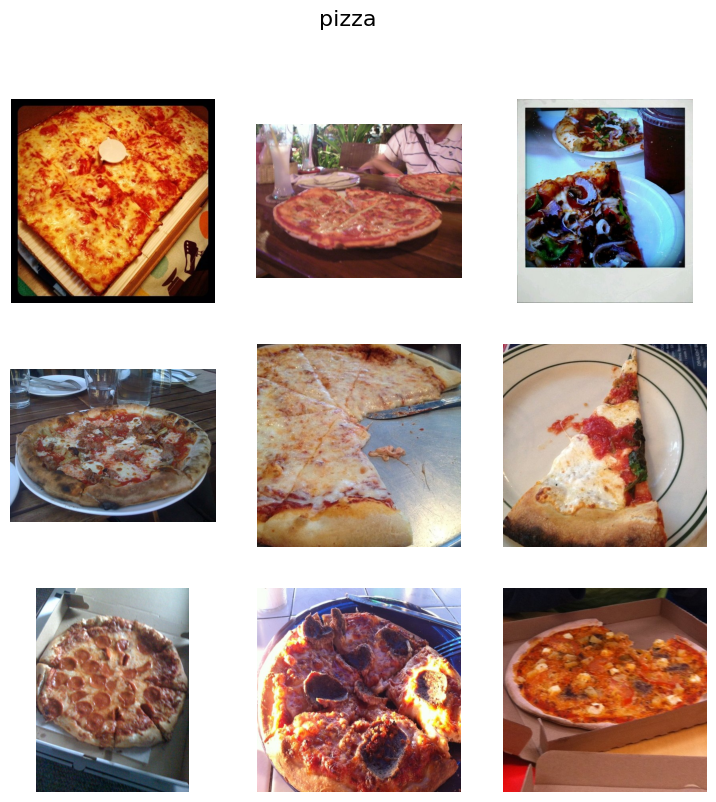

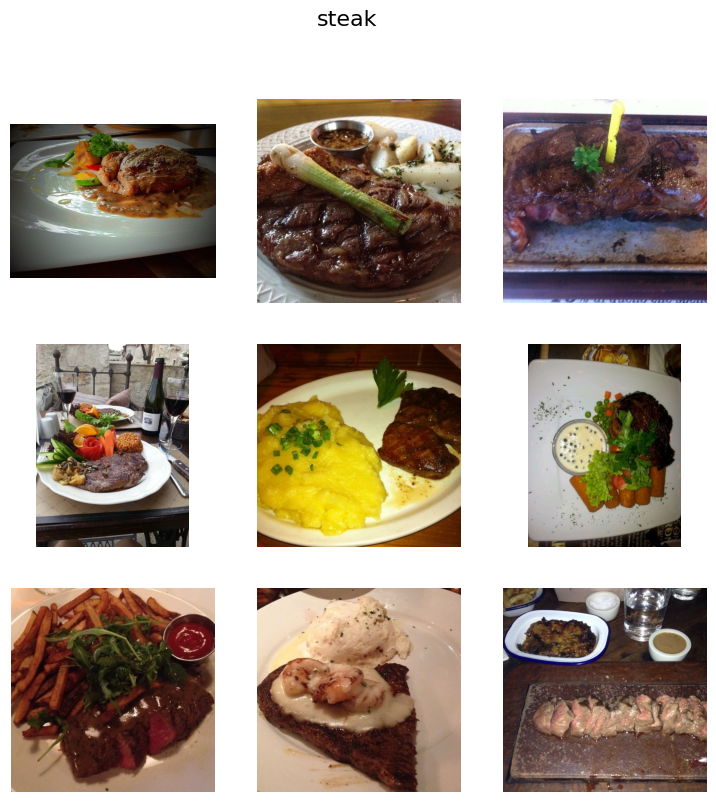

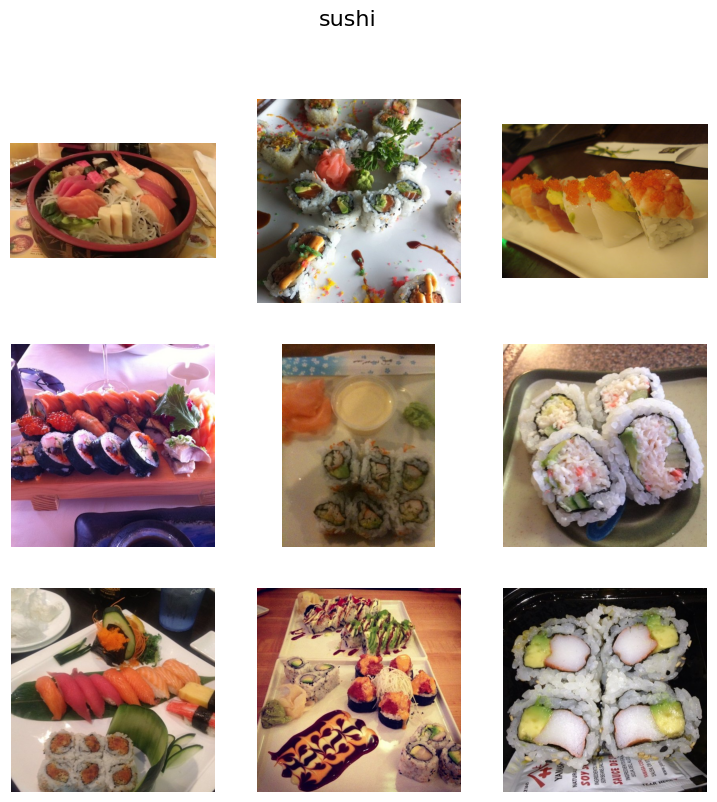

In [42]:
for i in train_dir.iterdir():
    showRandomImgFromDir(dir_path=i,
                  rows=3,
                  cols=3)

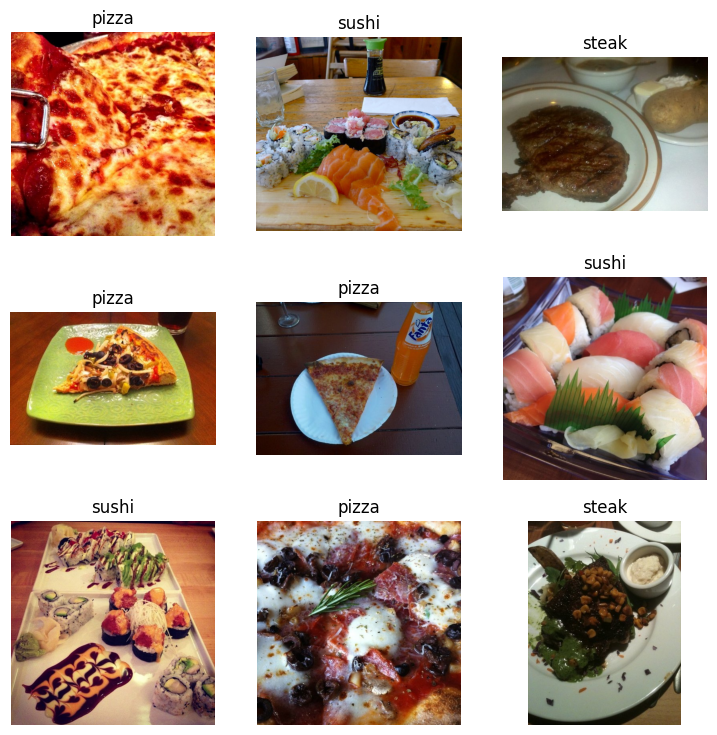

In [10]:
showRandomImg(images=all_imgs)

### Transforming (and still visualizing) data

In [13]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5), #to make the training better
    transforms.ToTensor()
])
data_transform_augment = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), #to make the training better
    transforms.ToTensor()
])

def tensorizeImage(image_path,transform: transforms.Compose = data_transform) -> torch.Tensor:
    """Takes an image and returns its tensor"""
    img_opened = Image.open(image_path)
    img_opened = transform(img_opened).to(device)
    return img_opened

def tensorizeImages(images: list,transform: transforms.Compose = data_transform) -> torch.Tensor:
    """Takes a list of image paths and converts them to Tensors using torchvision's Compose function"""
    tensors = torch.randn((len(images),3,64,64))
    for i in range(len(images)):
        tensoredImage =tensorizeImage(images[i],transform)
        tensors[i] = tensoredImage
    return tensors

def compareRandomImageWithTensor(images: list) -> None:
    """Compare a random image from a given list of image paths with it's tensorized version."""
    image_path = random.choice(images)
    img_opened = Image.open(image_path)
    img_tensor = tensorizeImage(image_path,data_transform).permute(dims=(1,2,0))
    plt.figure(figsize=(5,5))
    plt.suptitle(f"Image of {image_path.parent.stem} with it's tensor.")
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(np.asarray(img_opened))
    plt.axis(False)
    plt.subplot(1,2,2)
    plt.title("Tensor")
    plt.imshow(img_tensor.cpu())
    plt.axis(False)
    plt.show()

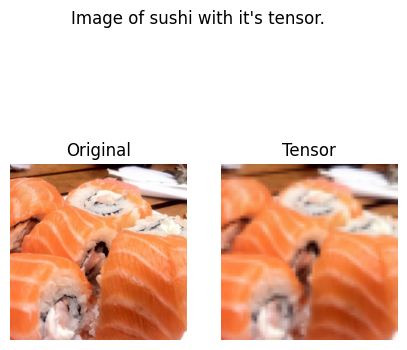

In [15]:
compareRandomImageWithTensor(all_imgs)

### Using `torchvision.datasets.ImageFolder`

In [16]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform, # for data
    target_transform=None # for label/target
)
test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)

In [17]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

In [18]:
img,label = train_data[0]

In [19]:
BATCH_SIZE = 8
NUM_WORKERS = 0

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [20]:
img,label = next(iter(train_dataloader))

img.shape

torch.Size([8, 3, 64, 64])

### Without using ImageFolder

In [21]:
from typing import Tuple,Dict,List
import pathlib

In [22]:
def find_classes(directory):
    class_names_found = sorted([entry.name for entry in list(os.scandir(directory))])
    class_names_idx = {class_name:i for i,class_name in enumerate(class_names_found)}
    return (class_names_found,class_names_idx)

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [23]:
class datasets_0(Dataset):
    def __init__(self,
                 root: str,
                 transform: transforms.Compose=data_transform) -> None:
        self.paths = list(pathlib.Path(root).glob("*/*.jpg"))
        self.transform = transform
        self.class_names,self.class_to_idx = find_classes(root)
    def load_image(self,index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    def __len__(self) -> int:
        return len(self.paths)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor,int]:
        image = self.transform(self.load_image(index)) if self.transform else self.load_image(self.paths[index])
        class_name = self.paths[index].parent.name
        label = self.class_to_idx[class_name]
        return image,label

In [24]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [25]:
train_data_custom = datasets_0(
    root = train_dir,
    transform=train_transforms
)
test_data_custom = datasets_0(
    root = test_dir,
    transform=test_transforms
)

In [26]:
def display_random_img_custom(
        dataset: Dataset,
        classes: List[str] = None,
        n: int = 10,
        display_shape: bool= True,
        seed: int = None
) -> None:
    if n>10:
        n=10
        display_shape = False
    
    if seed:
        random.seed(seed)

    plt.figure(figsize=(9,9))

    random_samples_idx = random.sample(range(len(dataset)),k=n)
    for i,target in enumerate(random_samples_idx):
        target_image,target_label = dataset[target]
        targest_image_adjust = target_image.permute(1,2,0)
        plt.subplot(1,n,i+1)
        plt.imshow(targest_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[target_label]}"
            if display_shape:
                title = title + f"\nshape: {targest_image_adjust.shape}"
        plt.title(title)

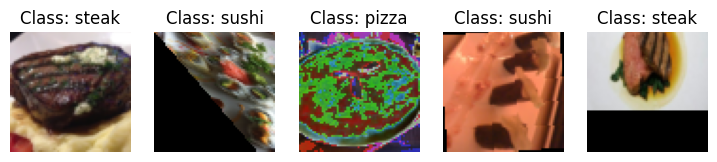

In [27]:
display_random_img_custom(train_data_custom,n=5,
                          classes=class_names,
                          display_shape=False,
                          seed=None)

In [28]:
BATCH_SIZE = 32
NUM_WORKERS = 0
SHUFFLE = True

train_dataloader_custom = DataLoader(
    train_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    num_workers=NUM_WORKERS
)

test_dataloader_custom = DataLoader(
    test_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

## Model

In [29]:
class Food101Model_0(nn.Module):
    def __init__(self,input_nums: int, output_nums: int, hidden_units: int=10) -> None:
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_nums,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=13*13*hidden_units,
                      out_features=output_nums)
        )
    def forward(self,x) -> torch.Tensor:
        '''
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)
        return x
        '''
        return self.classifier(self.conv_layer_2(self.conv_layer_1(x)))

In [36]:
LEARNING_RATE=0.01
HIDDEN_UNITS=10
EPOCHS = 5

In [37]:
model_0 = Food101Model_0(input_nums=3,output_nums=len(class_names),hidden_units=HIDDEN_UNITS).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(
    params=model_0.parameters(),
    lr = LEARNING_RATE
)


### Pre-made training and testing steps and other stuff

In [33]:
from timeit import default_timer as timer
#!pip install tqdm  
from tqdm.auto import tqdm

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_time(start: float,
               end: float,
               device: torch.device=None):
    """Prints the training duration."""
    total_time = end-start
    print(f"\nDevice: {device}\nTime:{total_time:.3f} seconds")

d:\computers\Python\Environments\Pytorch cuda env\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
def train_step(model: nn.Module,
               loss_fn: nn.Module,
               data_loader: DataLoader,
               optimizer: optim.Optimizer,
               device: torch.device = device) -> None:
    train_acc,train_loss = 0,0
    model.train()
    for batch,(X,y) in enumerate(data_loader):

        X,y = X.to(device),y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred,y)
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc+=(y_pred_class==y).sum().item()/len(y_pred)
        train_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc /= len(data_loader)
    train_loss /= len(data_loader)
    
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}")

def test_step(model: nn.Module,
               loss_fn: nn.Module,
               data_loader: DataLoader,
               device: torch.device = device) -> None:
    test_loss,test_accuracy = 0,0
    model.eval()

    for bacth,(X,y) in enumerate(test_dataloader):
        X,y = X.to(device),y.to(device)

        with torch.inference_mode():
            y_pred =model(X)
            loss = loss_fn(y_pred,y)
            test_loss+=loss.item()
            y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
            test_accuracy+=(y_pred_class==y).sum().item()/len(y_pred)
    test_loss /= len(data_loader)
    test_accuracy /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_accuracy:.5f}")

def print_dict(dictionary: dict):
    print()
    for i,j in dictionary.items():
        print(f"{i}: {j}")

def eval_model(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               accuracy_fn) -> dict:
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {'model_name':model.__class__.__name__,
    'model_loss': loss.item(),
    'model_accuracy' :acc}

def make_predictions(
        model: nn.Module,
        data: list,
        device: torch.device = device
):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.unsqueeze(dim=0)
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(),dim=0)
            prediction = pred_prob.argmax()
            pred_probs.append(pred_prob.cpu())

        return torch.stack(pred_probs)

In [40]:
from torchinfo import summary

summary(model_0,input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
Food101Model_0                           [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Loops

In [41]:
train_time_start = timer()

for epoch in tqdm(range(EPOCHS)):
    train_step(
        model=model_0,
        loss_fn=loss_fn,
        data_loader=train_dataloader,
        optimizer=optimizer,
        device=device
    )
    test_step(
        model=model_0,
        loss_fn=loss_fn,
        data_loader=test_dataloader,
        device=device
    )

train_time_end = timer()

train_time(train_time_start,train_time_end)

print_dict(eval_model(model_0,test_dataloader,loss_fn,accuracy_fn))

 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

Train loss: 1.08217 | Train acc: 0.50000
Test loss: 1.08660 | Test acc: 0.32500


 40%|████      | 2/5 [00:01<00:02,  1.29it/s]

Train loss: 1.06981 | Train acc: 0.47414
Test loss: 1.08657 | Test acc: 0.32500
Train loss: 1.05464 | Train acc: 0.47414
Test loss: 1.10589 | Test acc: 0.25000


 80%|████████  | 4/5 [00:03<00:00,  1.31it/s]

Train loss: 1.03453 | Train acc: 0.48707
Test loss: 1.15364 | Test acc: 0.23750


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

Train loss: 0.97660 | Train acc: 0.56034
Test loss: 1.17017 | Test acc: 0.26250


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]



Device: None
Time:3.863 seconds


100%|██████████| 10/10 [00:00<00:00, 52.44it/s]


model_name: Food101Model_0
model_loss: 1.1694320440292358
model_accuracy: 26.25
